# Imports

In [100]:
from learntools.utils import plot_periodogram, seasonal_plot, lagplot, plot_lags, make_lags, make_leads, create_multistep_example, load_multistep_data, make_multistep_target, plot_multistep
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

# plt.style.available
plt.style.use("seaborn-v0_8-whitegrid")

plot_params = {'color': '0.75',
 'style': '.-',
 'markeredgecolor': '0.25',
 'markerfacecolor': '0.25',
 'legend': False}

data_dir = Path('data/kaggle/courses/time-series')
comp_dir = Path('data/kaggle/courses/store-sales-time-series-forecasting')

# Linear Regression

In [2]:
book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

C:\Users\jgibb\AppData\Local\Temp\ipykernel_34204\2244095323.py:18: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


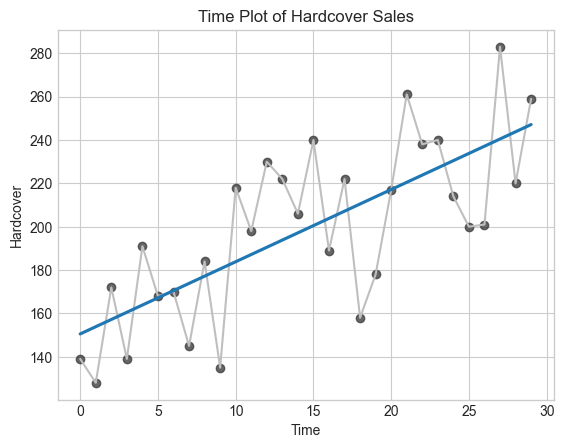

In [3]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

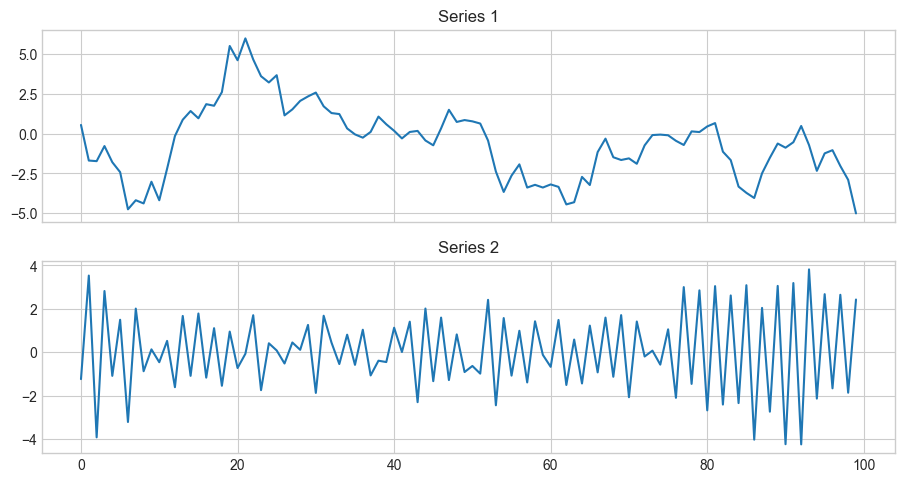

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');
# Series 1 was generated by target = 0.95 * lag_1 + error and Series 2 was generated by target = -0.95 * lag_1 + error.

In [5]:
df = average_sales.to_frame()

# Create a time dummy
time = np.arange(len(df.index))
df['time'] = time 

# Create training data
X = df.loc[:, ['time']]
y = df.loc[:, 'sales']

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

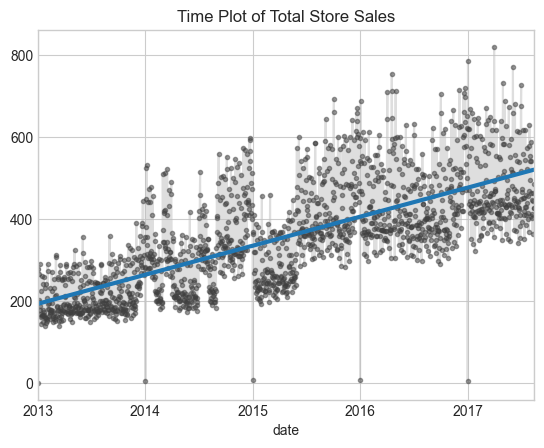

In [6]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

In [7]:
df = average_sales.to_frame()

lag_1 = df['sales'].shift(1)
df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

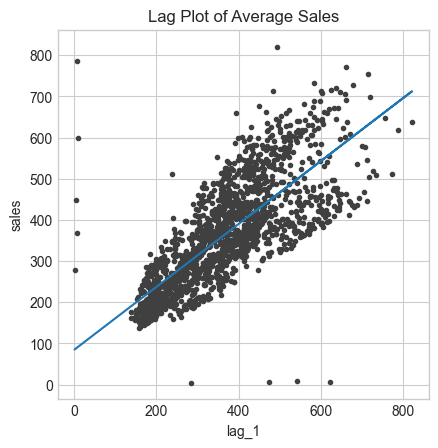

In [8]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

# Trends

In [9]:
retail_sales = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

C:\Users\jgibb\AppData\Local\Temp\ipykernel_34204\3065125058.py:15: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


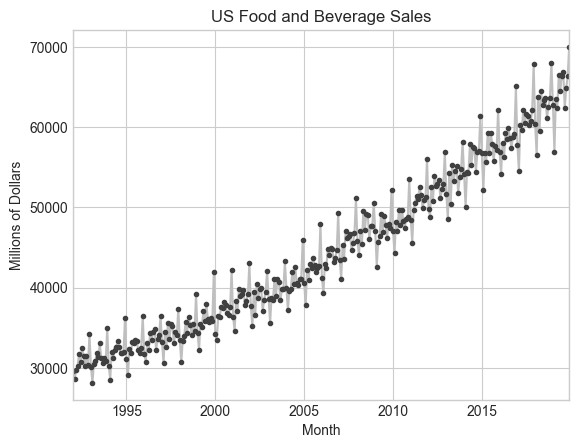

In [10]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

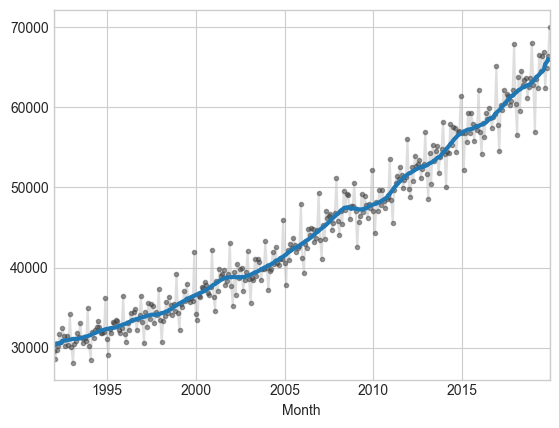

In [11]:
trend = food_sales.rolling(
    window=12,        # 12 because food sales is monthly
    min_periods=6,    # Half window
    center=True,
).mean()

ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# Looks roughly quadratic

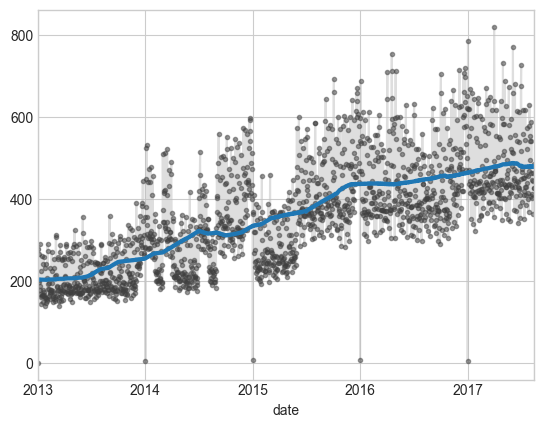

In [12]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# Possibly cubic (third-order polynominal)

In [13]:
y = average_sales.copy()

dp = DeterministicProcess(
    index=y.index,       # dates from the training data
    # constant=True,     # dummy feature for the bias (y_intercept) - not in this one
    order=3,             # third-order i.e. cubic
    drop=True,           # drop terms if necessary to avoid collinearity
)

X = dp.in_sample()
X_forecast = dp.out_of_sample(steps=90)

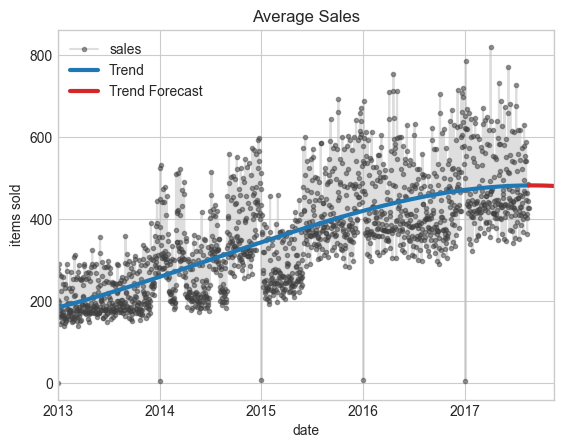

In [14]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_forecast), index=X_forecast.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

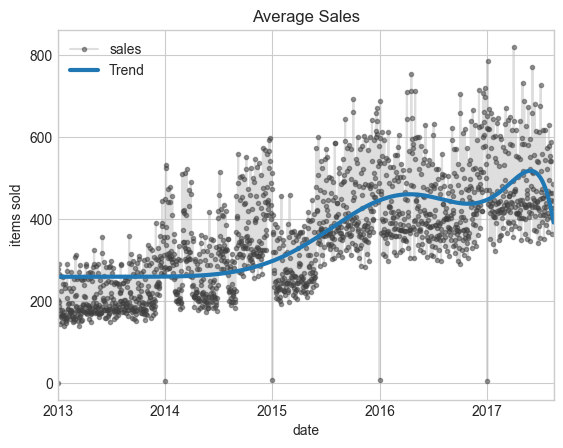

In [15]:
dp = DeterministicProcess(index=y.index, order=11)  # Stupidly-high-order polynomial
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

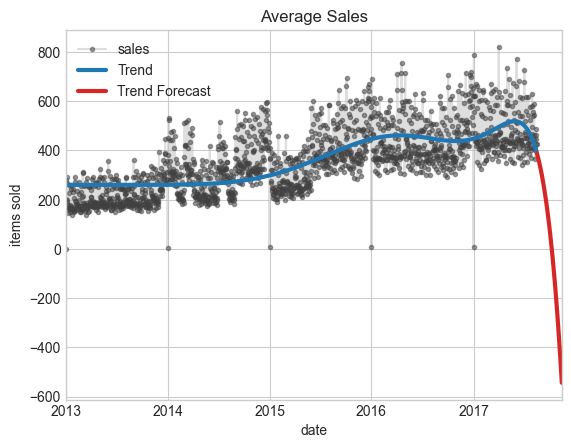

In [16]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

# Seasonality

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

Linear regression works best if you drop one of the indicators.

Use a periodogram to determine how many Fourier pairs to include in a feature set.

In [17]:
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

C:\Users\jgibb\AppData\Local\Temp\ipykernel_34204\1219379336.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays_events = pd.read_csv(
C:\Users\jgibb\AppData\Local\Temp\ipykernel_34204\1219379336.py:15: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


c:\Users\jgibb\Google Drive\My Drive\Colab Notebooks\learntools\utils.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


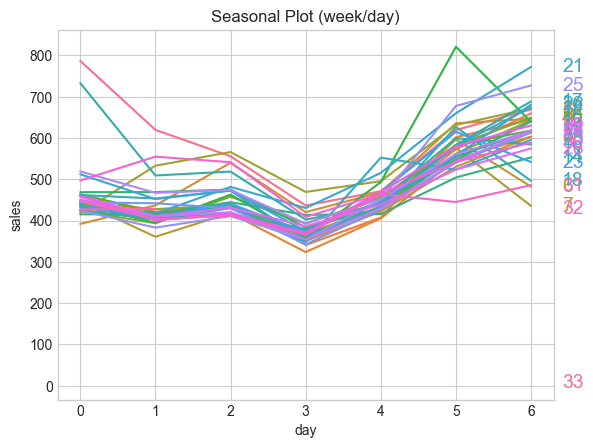

In [18]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

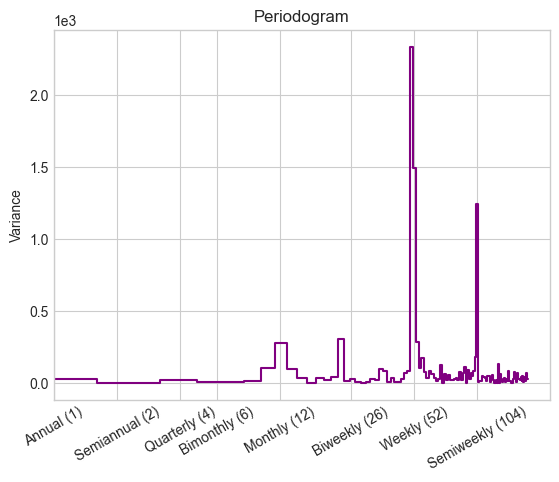

In [19]:
plot_periodogram(average_sales);

In [20]:
y = average_sales.copy()

fourier = CalendarFourier(freq="M", order=4)  # 4 sin/cos pairs for "M"onthly seasonality
dp = DeterministicProcess(
    index=y.index,
    constant=True,                   # dummy feature for bias (y-intercept)
    order=1,                         # trend (order 1 means linear)
    seasonal=True,                   # weekly seasonality (indicators)
    additional_terms=[fourier],      # monthly seasonality (fourier)
    drop=True,                       # drop terms to avoid collinearity
)
X = dp.in_sample()

c:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


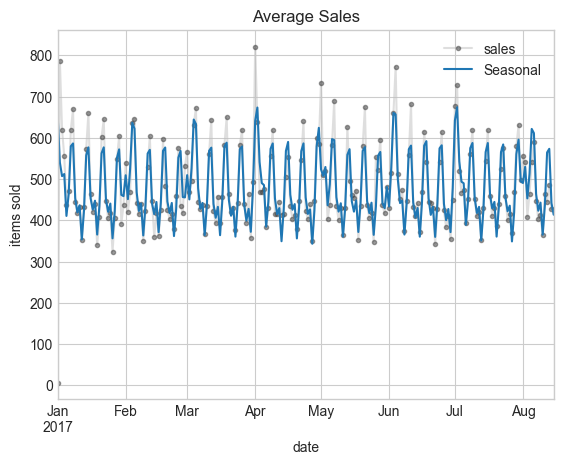

In [21]:
model = LinearRegression().fit(X, y)
y_pred1 = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred1.plot(ax=ax, label="Seasonal")
ax.legend();

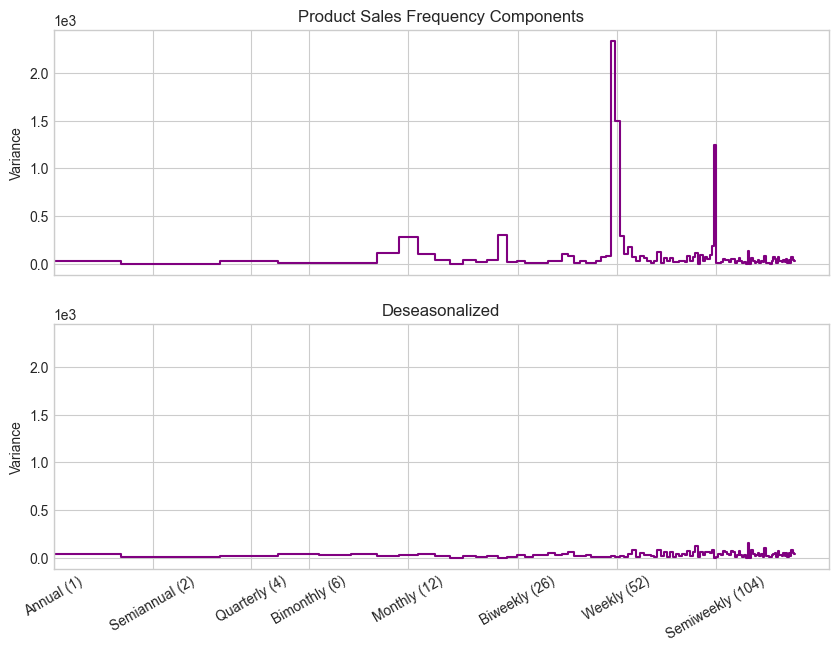

In [22]:
y_deseason1 = y - y_pred1

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason1, ax=ax2);
ax2.set_title("Deseasonalized");

In [23]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


C:\Users\jgibb\AppData\Local\Temp\ipykernel_34204\3451743685.py:2: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(holidays.index, y_deseason1[holidays.index], color='C3')


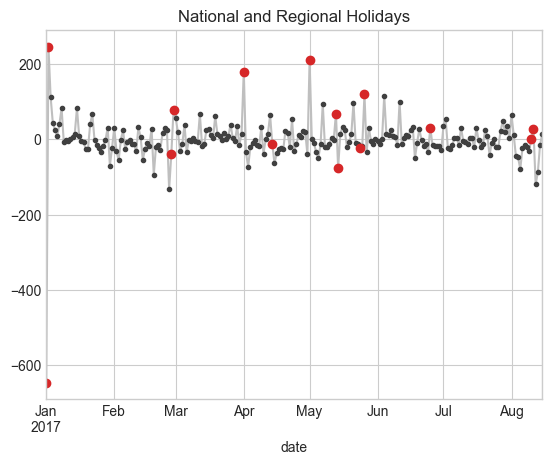

In [24]:
ax = y_deseason1.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason1[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

In [25]:
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

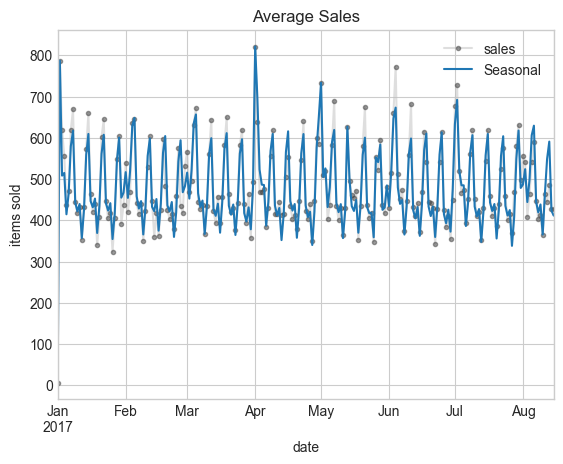

In [26]:
model = LinearRegression().fit(X2, y)
y_pred2 = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred2.plot(ax=ax, label="Seasonal")
ax.legend();

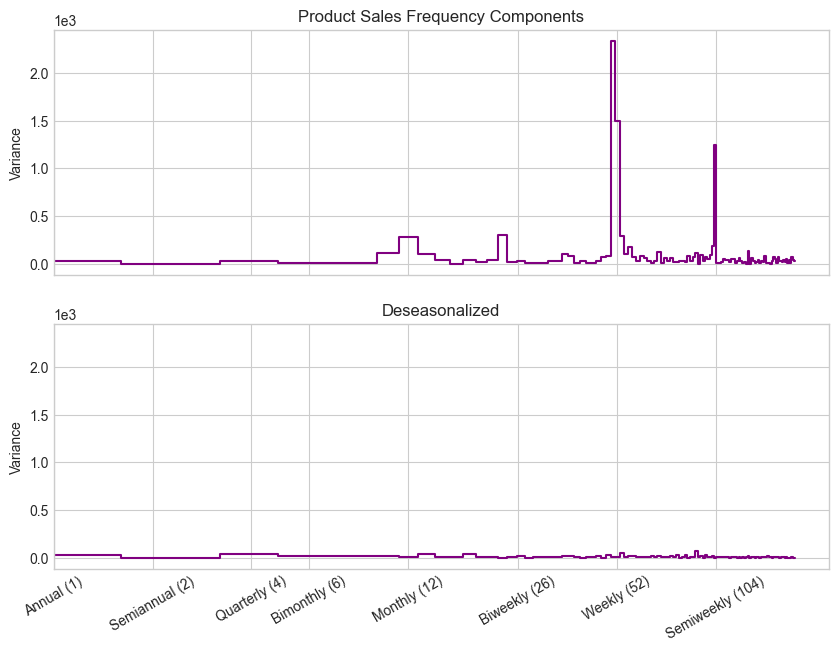

In [27]:
y_deseason2 = y - y_pred2

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason2, ax=ax2);
ax2.set_title("Deseasonalized");

# Time Series as Features

In [28]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

C:\Users\jgibb\AppData\Local\Temp\ipykernel_34204\4140110670.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(
C:\Users\jgibb\AppData\Local\Temp\ipykernel_34204\4140110670.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['family', 'date'])


c:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


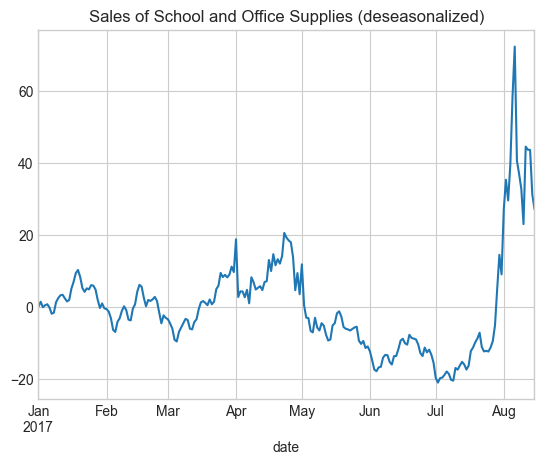

In [29]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

# ax = y.plot()
ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

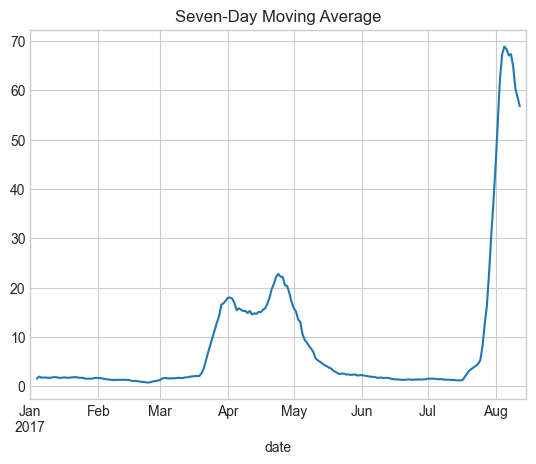

In [30]:
y_ma = y.rolling(
    window=7,        # 7 days
    center=True,
).mean()

ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

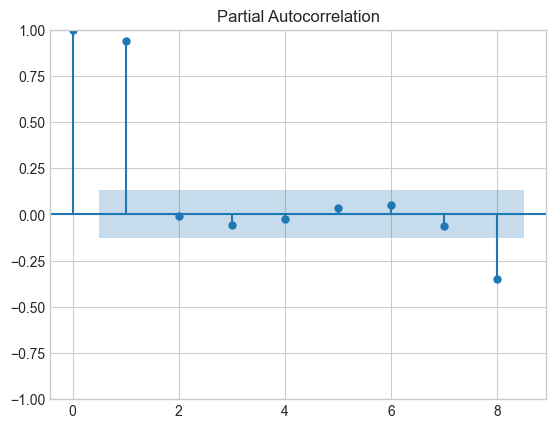

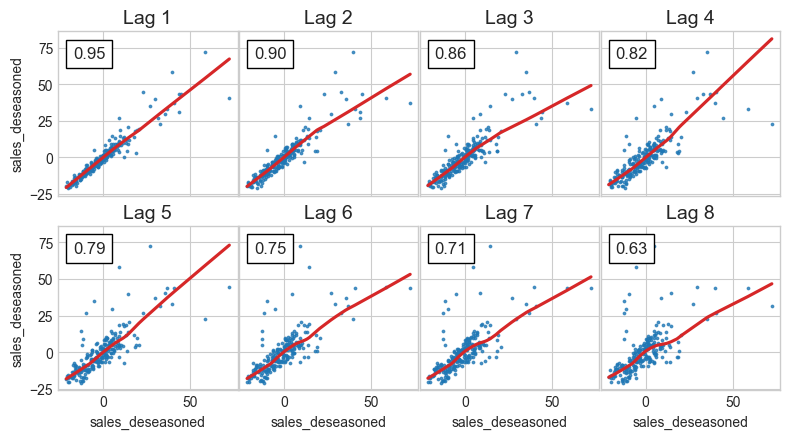

In [31]:
plot_pacf(y_deseason, lags=8); # ignore those outside blue zone
plot_lags(y_deseason, lags=8, nrows=2); # higher is better

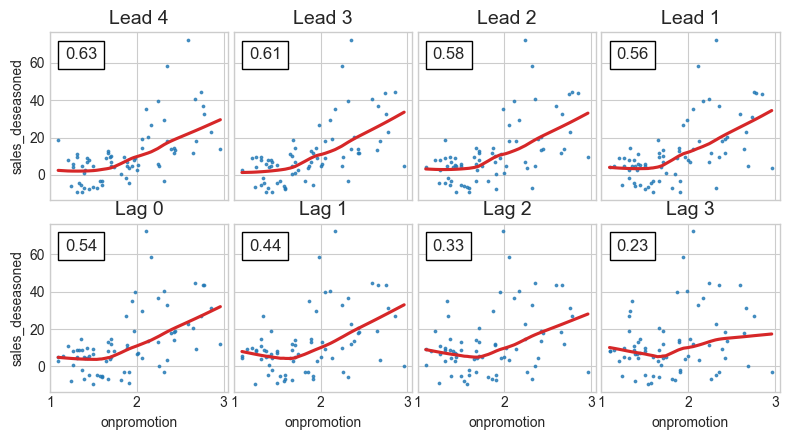

In [32]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=4, nrows=2);

# indicates leading and lagging features

In [33]:
# Make features from `y_deseason`
X_lags = make_lags(y_deseason, lags=1)

# Make features from `onpromotion`
X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1)
], axis=1)

X = pd.concat([X_time, X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

Training RMSLE: 0.23893
Validation RMSLE: 0.34245


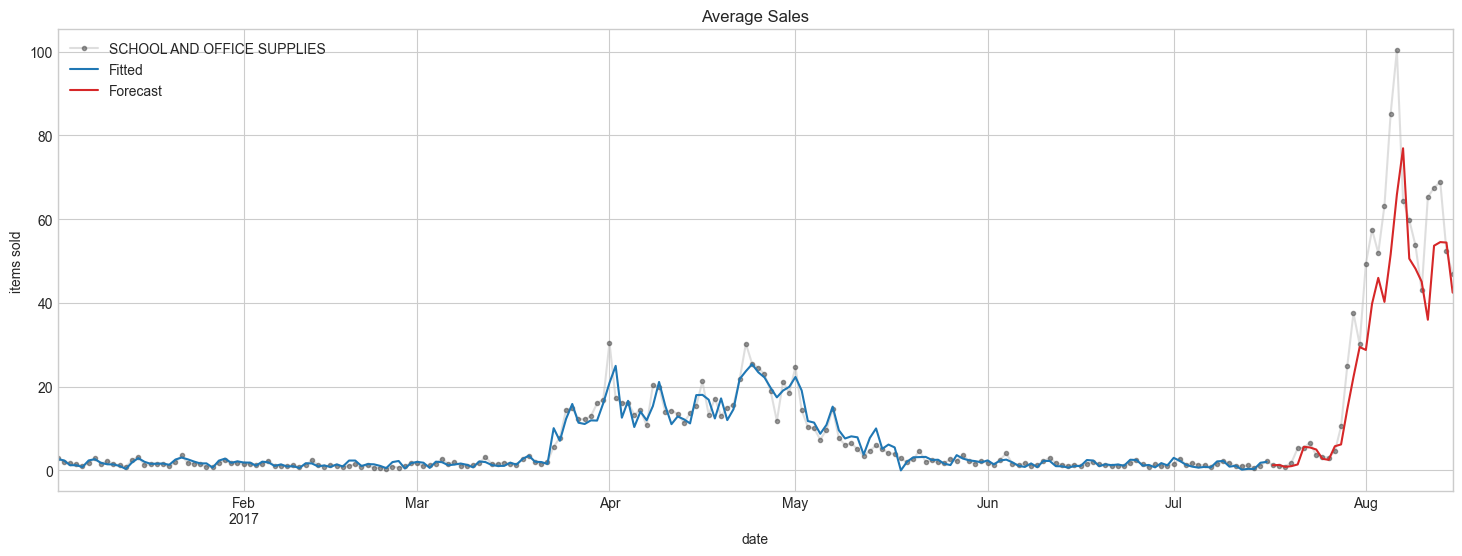

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

plt.figure(figsize=(18,6))
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend()

In [35]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

mean_7 = y_lag.rolling(7).mean()                  # 28-day mean of lagged target
median_14 = y_lag.rolling(14).median()            # 14-day median of lagged target
std_7 = y_lag.rolling(7).std()                    # 7-day rolling standard deviation of lagged target
promo_7 = onpromo.rolling(7, center=True).sum()   # 7-day sum of promotions with centered window

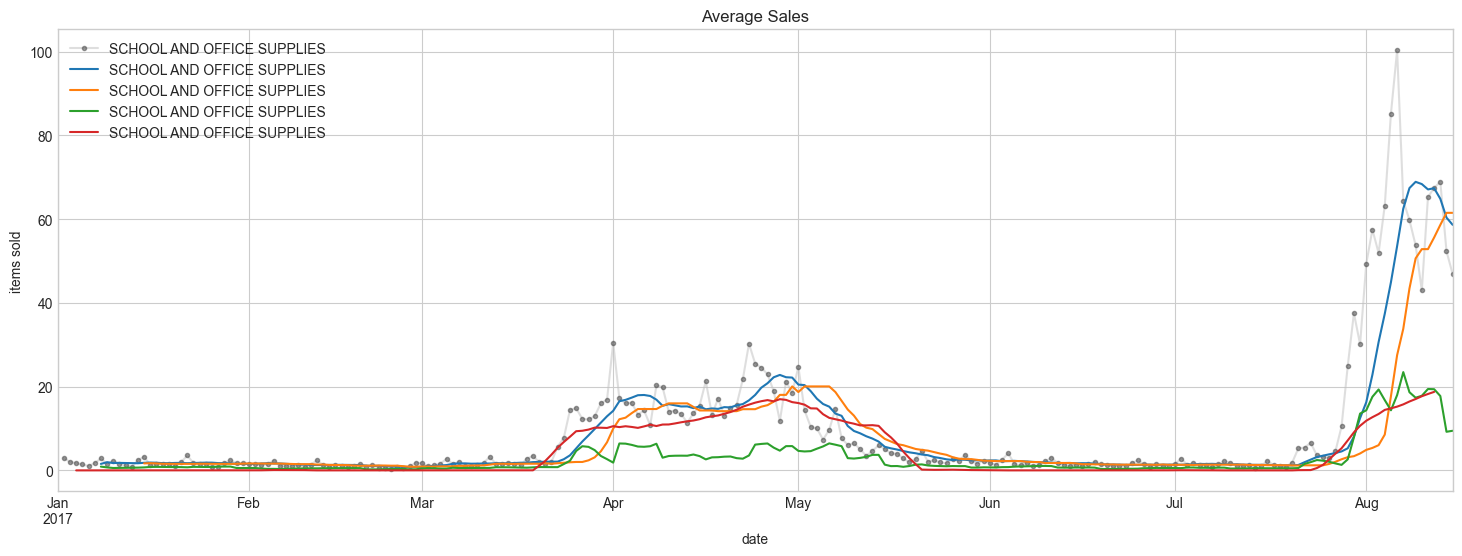

In [36]:
plt.figure(figsize=(18,6))
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = mean_7.plot(ax=ax, label="mean 7")
ax = median_14.plot(ax=ax, label="median 14")
ax = std_7.plot(ax=ax, label="std 7")
ax = promo_7.plot(ax=ax, label="promo 7")
ax.legend()

# Hybrid Models

Feature transformers generally can extrapolate target values beyond the training set given appropriate features as inputs.

Predictions of target transformers will always be bound within the range of the training set.

Decision trees (inc. RF, XGB) cannot extrapolate trends.

The method of fitting to residuals is the same method the gradient boosting algorithm uses, so we will call these boosted hybrids.

The method of using predictions as features is known as "stacking", so we will call these stacked hybrids.

In [69]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    # infer_datetime_format=True, # depreciated
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'], observed=False)
    .mean()
    .unstack('family')
    .loc['2017']
)

<Axes: xlabel='date'>

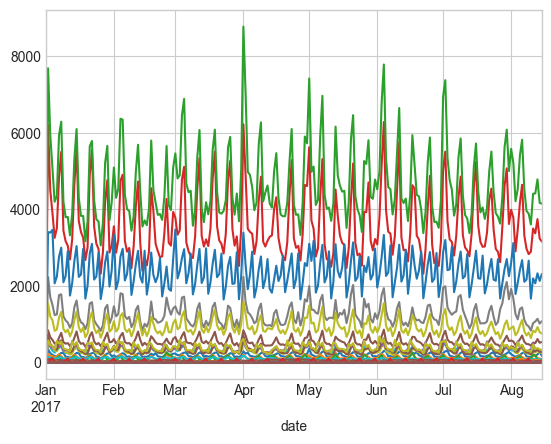

In [38]:
family_sales.plot(legend=False)

In [39]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index,
            columns=y.columns,
        )

        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        y_pred += self.model_2.predict(X_2)
        
        return y_pred.unstack()  # long to wide

In [70]:
# Target series
y = family_sales.loc[:, 'sales']

# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack(future_stack=True)  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [71]:
# model = BoostedHybrid(LinearRegression(), XGBRegressor())
model = BoostedHybrid(Ridge(), KNeighborsRegressor())
# note some models work better with standardisation

model.fit(X_1, X_2, y)
y_pred = X_1

y_pred = y_pred.clip(0.0)

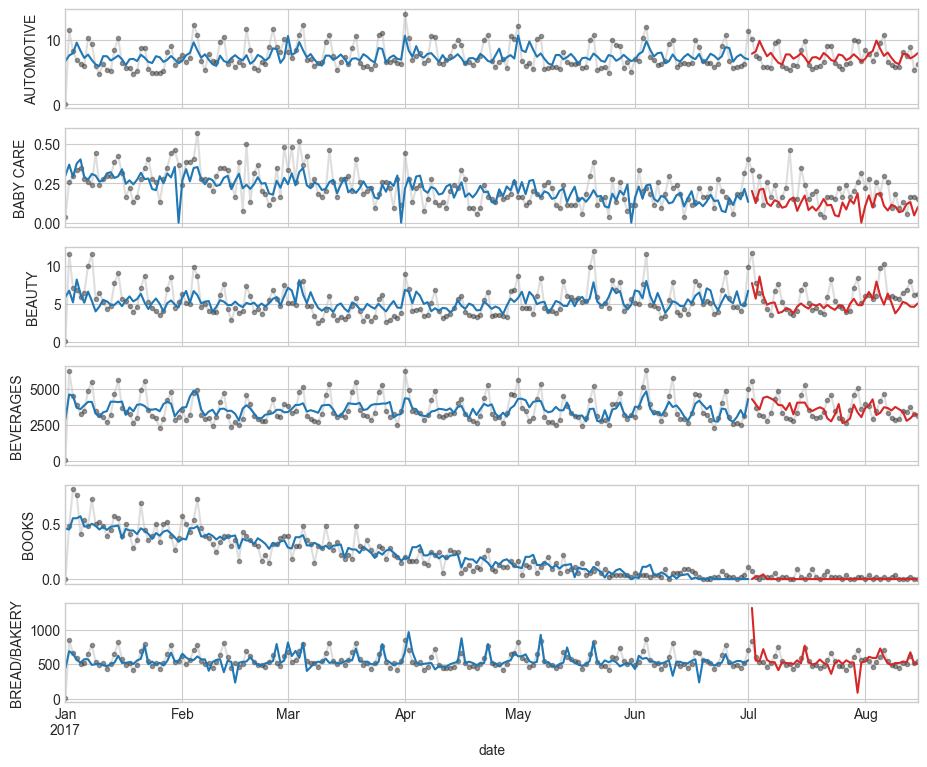

In [74]:
# y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":] # not working for unknown reason
y_train, y_valid = y.iloc[:182], y.iloc[182:]
X1_train, X1_valid = X_1[:"2017-07-01"], X_1["2017-07-02":]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

# Forecasting With Machine Learning

In [76]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    # infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'], observed=False)
    .mean()
    .unstack('family')
    .loc['2017']
)

test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    # infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [80]:
datasets = load_multistep_data()

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets)])
for i, df in enumerate(datasets):
    data_tabs.set_title(i, f'Dataset {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

c:\Users\jgibb\Google Drive\My Drive\Colab Notebooks\learntools\utils.py:222: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  index=pd.period_range(start='2010', freq='A', periods=n, name='Year'),
c:\Users\jgibb\Google Drive\My Drive\Colab Notebooks\learntools\utils.py:220: UserWarning: Instantiating Int8Dtype without any arguments.Pass a Int8Dtype instance to silence this warning.
  ts = pd.Series(
c:\Users\jgibb\Google Drive\My Drive\Colab Notebooks\learntools\utils.py:222: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  index=pd.period_range(start='2010', freq='A', periods=n, name='Year'),
c:\Users\jgibb\Google Drive\My Drive\Colab Notebooks\learntools\utils.py:220: UserWarning: Instantiating Int8Dtype without any arguments.Pass a Int8Dtype instance to silence this warning.
  ts = pd.Series(
c:\Users\jgibb\Google Drive\My Drive\Colab Notebooks\learntools\utils.py:222: FutureWarnin

In [88]:
y = family_sales.loc[:, 'sales']
X = make_lags(y, lags=4).dropna()
y = make_multistep_target(y, steps=16).dropna()
y, X = y.align(X, join='inner', axis=0)

In [89]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

C:\Users\jgibb\AppData\Local\Temp\ipykernel_34204\3444948386.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack('family')  # wide to long
C:\Users\jgibb\AppData\Local\Temp\ipykernel_34204\3444948386.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y = y.stack('family')  # wide to long


y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.333333     6.018518    10.259259   
           BABY CARE                      0.351852     0.277778     0.259259   
           BEAUTY                         5.925926     6.518518    10.037037   
           BEVERAGES                   3258.796387  3507.277832  4848.518555   
           BOOKS                          0.407407     0.537037     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313995   
           PREPARED FOODS                84.698647    87.836800    88.735970   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     9.388889     5.944445     4.777778   
           BABY CARE                      0.240741     0.444444     0.240741   
           BEAUTY                        11.611111     5.648148     6.500000   
           BEVERAGES                   5503.647949  3448.203613  3171.740723   
           BOOKS                          0.722222     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497009   416.454041   
           PREPARED FOODS                77.172997    91.886765   100.384964   
           PRODUCE                     1792.220947  2079.319336  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553965    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.314815     5.388889     5.240741   
           BABY CARE                      0.277778     0.296296     0.296296   
           BEAUTY                         5.277778     4.370370     4.703704   
           BEVERAGES                   3046.870361  2693.722168  3226.037109   
           BOOKS                          0.481481     0.388889     0.444444   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051758   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105957  2111.133301  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     8.500000    10.259259     6.407407   
           BABY CARE                      0.388889     0.425926     0.314815   
           BEAUTY                         7.777778     9.037037     5.648148   
           BEVERAGES                   4667.296387  5580.611328  3700.370361   
           BOOKS                          0.574074     0.555556     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270233   278.819885   468.857391   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076416  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

train_rmse = root_mean_squared_error(y_train, y_fit)
test_rmse = root_mean_squared_error(y_test, y_pred)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
# ax1 = family_sales.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
# _ = ax1.legend(['FluVisits (train)', 'Forecast'])
# ax2 = family_sales.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
# ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
# _ = ax2.legend(['FluVisits (test)', 'Forecast'])

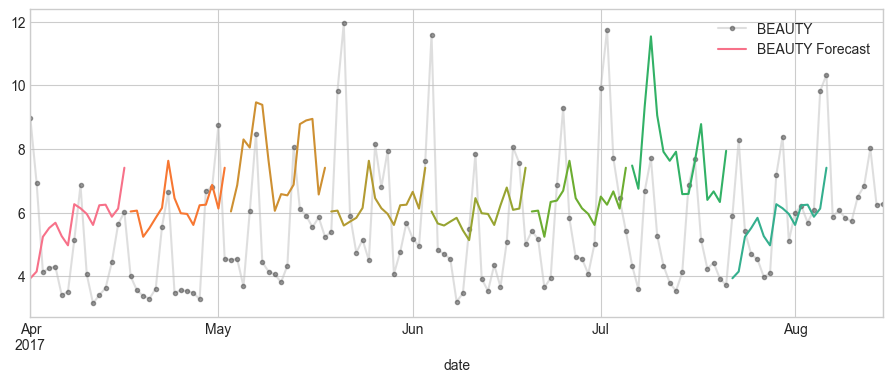

In [118]:
model = RegressorChain(XGBRegressor())
model.fit(X, y)
y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

In [108]:
model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [114]:
model = RegressorChain(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns).clip(0.0)

# Competition

In [ ]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [ ]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');